In [1]:
import glob
import numpy as np
import os
import shutil
import pandas as pd
np.random.seed(42)
from google.cloud import storage

In [15]:
! gsutil cp gs://dog-vs-cat-arnaud-test/dog-vs-cat /tmp/train.zip

Copying gs://dog-vs-cat-arnaud-test/dog-vs-cat...
/ [1 files][543.2 MiB/543.2 MiB]                                                
Operation completed over 1 objects/543.2 MiB.                                    


In [18]:
import zipfile

In [19]:
local_zip = '/tmp/train.zip' # local path of downloaded .zip file
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/train-unzip') # contents are extracted to '/tmp' folder
zip_ref.close()

In [2]:
### Not useful

# Instantiates a client
storage_client = storage.Client()

In [3]:
### Not usefuk

# Define bucket name
bucket_name = 'dog-vs-cat-arnaud-test'

In [14]:
### Not useful

# Get GCS bucket
bucket = storage_client.get_bucket(bucket_name)

In [21]:
### Not useful

# Retrieve blobs in the train dataset
blobs = bucket.list_blobs(prefix='dog-vs-cat/train/')

In [16]:
### Not useful

# Retrieve list of blobs
blob_list = []
for blob in blobs:
    blob_list.append(blob.name)

In [17]:
### Not useful

blob_list.remove('dog-vs-cat/train/')

In [24]:

files = glob.glob('/tmp/train-unzip/train/*')

cat_files = [fn for fn in files if 'cat' in fn]
dog_files = [fn for fn in files if 'dog' in fn]
len(cat_files), len(dog_files)

(12500, 12500)

In [25]:
cat_train = np.random.choice(cat_files, size=1500, replace=False)
dog_train = np.random.choice(dog_files, size=1500, replace=False)
cat_files = list(set(cat_files) - set(cat_train))
dog_files = list(set(dog_files) - set(dog_train))

cat_val = np.random.choice(cat_files, size=500, replace=False)
dog_val = np.random.choice(dog_files, size=500, replace=False)
cat_files = list(set(cat_files) - set(cat_val))
dog_files = list(set(dog_files) - set(dog_val))

cat_test = np.random.choice(cat_files, size=500, replace=False)
dog_test = np.random.choice(dog_files, size=500, replace=False)

print('Cat datasets:', cat_train.shape, cat_val.shape, cat_test.shape)
print('Dog datasets:', dog_train.shape, dog_val.shape, dog_test.shape)

Cat datasets: (1500,) (500,) (500,)
Dog datasets: (1500,) (500,) (500,)


In [26]:
train_files = np.concatenate([cat_train, dog_train])
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

In [28]:
train_dir = 'training_data'
val_dir = 'validation_data'
test_dir = 'test_data'

train_files = np.concatenate([cat_train, dog_train])
validate_files = np.concatenate([cat_val, dog_val])
test_files = np.concatenate([cat_test, dog_test])

os.mkdir(train_dir) if not os.path.isdir(train_dir) else None
os.mkdir(val_dir) if not os.path.isdir(val_dir) else None
os.mkdir(test_dir) if not os.path.isdir(test_dir) else None

for fn in train_files:
    shutil.copy(fn, train_dir)

for fn in validate_files:
    shutil.copy(fn, val_dir)
    
for fn in test_files:
    shutil.copy(fn, test_dir)

# RUN CHECK POINT - CAN RUN FROM HERE

In [1]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
%matplotlib inline

Using TensorFlow backend.
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.5/dist-packages/tensorflow/python/framework/dtypes.py:519: FutureWarn

In [2]:
IMG_DIM = (150, 150)

train_files = glob.glob('training_data/*')
train_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in train_files]
train_imgs = np.array(train_imgs)
train_labels = [fn.split('/')[1].split('.')[0].strip() for fn in train_files]

validation_files = glob.glob('validation_data/*')
validation_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in validation_files]
validation_imgs = np.array(validation_imgs)
validation_labels = [fn.split('/')[1].split('.')[0].strip() for fn in validation_files]

print('Train dataset shape:', train_imgs.shape, 
      '\tValidation dataset shape:', validation_imgs.shape)

Train dataset shape: (3000, 150, 150, 3) 	Validation dataset shape: (1000, 150, 150, 3)


(150, 150, 3)


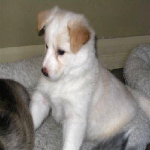

In [3]:
train_imgs_scaled = train_imgs.astype('float32')
validation_imgs_scaled  = validation_imgs.astype('float32')
train_imgs_scaled /= 255
validation_imgs_scaled /= 255

print(train_imgs[0].shape)
array_to_img(train_imgs[0])

In [4]:
batch_size = 30
num_classes = 2
epochs = 30
input_shape = (150, 150, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
validation_labels_enc = le.transform(validation_labels)

print(train_labels[1495:1505], train_labels_enc[1495:1505])

['dog', 'cat', 'cat', 'dog', 'cat', 'cat', 'dog', 'dog', 'dog', 'cat'] [1 0 0 1 0 0 1 1 1 0]


In [5]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])

model.summary()







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
____________________

In [6]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1)


Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 76s 25ms/step - loss: 8.0068 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/30
3000/3000 [==============================] - 72s 24ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/30
3000/3000 [==============================] - 72s 24ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/30
3000/3000 [==============================] - 72s 24ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/30
3000/3000 [==============================] - 72s 24ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 6/30
3000/3000 [==============================] - 72s 24ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 7/30
3000/3000 [==============================] - 72s 24ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000

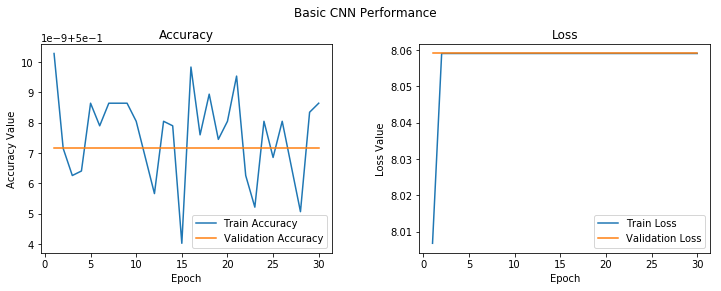

In [7]:

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [8]:
model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))


model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(),
              metrics=['accuracy'])
              
              
history = model.fit(x=train_imgs_scaled, y=train_labels_enc,
                    validation_data=(validation_imgs_scaled, validation_labels_enc),
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1) 

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Train on 3000 samples, validate on 1000 samples
Epoch 1/30
3000/3000 [==============================] - 59s 20ms/step - loss: 7.7992 - acc: 0.4937 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/30
3000/3000 [==============================] - 58s 19ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/30
3000/3000 [==============================] - 58s 19ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/30
3000/3000 [==============================] - 58s 19ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/30
3000/3000 [==============================] - 58s 19ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 6/30
3000/3000 [==============================] - 57s 19ms/step - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 7/30
3000/3000 

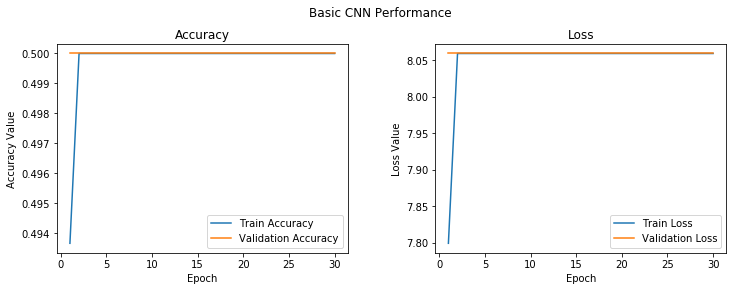

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
t = f.suptitle('Basic CNN Performance', fontsize=12)
f.subplots_adjust(top=0.85, wspace=0.3)

epoch_list = list(range(1,31))
ax1.plot(epoch_list, history.history['acc'], label='Train Accuracy')
ax1.plot(epoch_list, history.history['val_acc'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 31, 5))
ax1.set_ylabel('Accuracy Value')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy')
l1 = ax1.legend(loc="best")

ax2.plot(epoch_list, history.history['loss'], label='Train Loss')
ax2.plot(epoch_list, history.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 31, 5))
ax2.set_ylabel('Loss Value')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss')
l2 = ax2.legend(loc="best")

In [11]:
model.save('cats_dogs_basic_cnn.h5')

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255, zoom_range=0.3, rotation_range=50,
                                   width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, 
                                   horizontal_flip=True, fill_mode='nearest')

val_datagen = ImageDataGenerator(rescale=1./255)

Labels: ['cat', 'cat', 'cat', 'cat', 'cat']


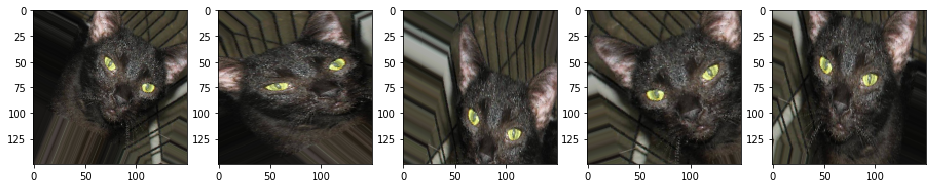

In [14]:
img_id = 2595
cat_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
cat = [next(cat_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(16, 6))
print('Labels:', [item[1][0] for item in cat])
l = [ax[i].imshow(cat[i][0][0]) for i in range(0,5)]

Labels: ['dog', 'dog', 'dog', 'dog', 'dog']


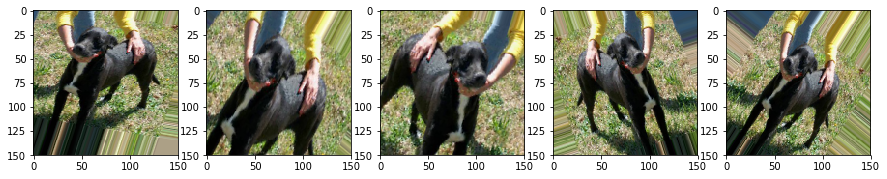

In [15]:

img_id = 1991
dog_generator = train_datagen.flow(train_imgs[img_id:img_id+1], train_labels[img_id:img_id+1],
                                   batch_size=1)
dog = [next(dog_generator) for i in range(0,5)]
fig, ax = plt.subplots(1,5, figsize=(15, 6))
print('Labels:', [item[1][0] for item in dog])
l = [ax[i].imshow(dog[i][0][0]) for i in range(0,5)]

In [ ]:
train_generator = train_datagen.flow(train_imgs, train_labels_enc, batch_size=30)
val_generator = val_datagen.flow(validation_imgs, validation_labels_enc, batch_size=20)
input_shape = (150, 150, 3)

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras import optimizers

model = Sequential()

model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', 
                 input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-4),
              metrics=['accuracy'])
              
history = model.fit_generator(train_generator, steps_per_epoch=100, epochs=100,
                              validation_data=val_generator, validation_steps=50, 
                              verbose=1)

Epoch 1/100
100/100 [==============================] - 69s 688ms/step - loss: 0.7012 - acc: 0.5070 - val_loss: 0.6911 - val_acc: 0.4910
Epoch 2/100
100/100 [==============================] - 68s 676ms/step - loss: 0.6938 - acc: 0.5267 - val_loss: 0.6826 - val_acc: 0.5520
Epoch 3/100
100/100 [==============================] - 67s 668ms/step - loss: 0.6867 - acc: 0.5563 - val_loss: 0.6719 - val_acc: 0.5900
Epoch 4/100
100/100 [==============================] - 67s 666ms/step - loss: 0.6761 - acc: 0.5777 - val_loss: 0.7243 - val_acc: 0.5150
Epoch 5/100
100/100 [==============================] - 67s 669ms/step - loss: 0.6699 - acc: 0.5890 - val_loss: 0.6489 - val_acc: 0.6200
Epoch 6/100
100/100 [==============================] - 67s 674ms/step - loss: 0.6556 - acc: 0.6040 - val_loss: 0.6286 - val_acc: 0.6570
Epoch 7/100
100/100 [==============================] - 66s 664ms/step - loss: 0.6512 - acc: 0.6137 - val_loss: 0.6499 - val_acc: 0.6270
Epoch 8/100
100/100 [===========================